In [1]:
from pymtj.junction import Layer, Junction
from pymtj.constants import Constants
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

constant = Constants()

In [2]:
fsize= 32
plt.rcParams['figure.figsize'] = [14, 10]
plt.rc('font', family='serif', serif='Times', size=18)
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=fsize)
plt.rc('ytick', labelsize=fsize)
plt.rc('axes', labelsize=fsize)

# Introduction

During this example, we will build a simplified macrospin model of the MTJ (Magnetic Tunnel Junction). 

One such junction could look like this:  

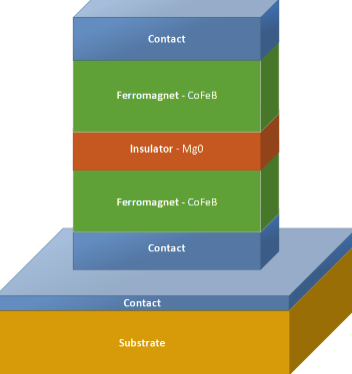
You can see two magnetic layers interlayed with a MgO spacer layer. The contact and substrate modelling will be skipped in our case. 

## The LLG equation and effective field interpretation

The PyMTJ solves the Landau-Lifschitz-Gilbert equation -- Gilbert's corretion introduces a damping parameter. Below, a pictorial representation of the LLG dynamics -- an effective field drives the magnetisation vector, while the damping term (dependent on the first derivative) introduces the interia to the system (rapid changes are quelled).
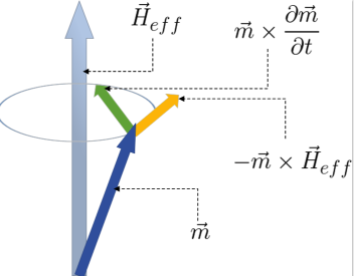




#### Conventional markings   
1. $\vec{m}_i$      the magnetisation vector of the $i$th layer. If not given, means the *current* layer.
2. $M_s$            is the magnetisation saturation. 
3. $\vec{H}$        is the vector field.  
4. $\gamma$         is the gyromagnetic factor
5. $\alpha$         is the Gilbert damping factor


##### The canonical form of the LLG equation, expanded for RK4:
$$\frac{d \vec{m}}{d t} = -\gamma_{0}\vec{m}\times \vec{H}_{\mathrm{eff}} - \gamma_{0}\alpha\vec{m}\times(\vec{m}\times\vec{H}_{\mathrm{eff}})$$

### Example

We will define two layers in our junction. 
The shape of both layers will have a ciruclar base, hence the demag and dipole tensors.
The dimensions of the base cyllinder is:
$$70x70xZ \ nm$$ where $Z$ is the height of the layer (also known as thickness), where the two layers are separated by the 1.4nm spacer.

#### Anisotropy
The top layer will have lower anisotropy and will be allowed to move, hence we call it *free* layer -- the magnetisation for that layer can move more freely, not bounded so strongly with the anisotropy energy. 

Anisotropies of both layers will be uniaxial, out of plane, so conventionally directed along the z-axis. In short, this means that any movement diverging from that direction will incur greater energy cost than remaining alinged along this axis.

# Layer definitions

## Demagnetisation tensor  and dipole tensor 
### Tensor interactions 
Declare tensors that will be used in the junction.
Usually tensors will be diagonal for macrospin interactions. Shape (dipole) tensors come from the structure shape and to the extend the shape is symmetric, the tensor will also reciprocate this symmetry.

Demagnetisation tensors can be explained as two shapes counterreacting to each other -- the field of the layer is trying to counterbalance the effect of the other.

Both interactions contribute in the same way to the effective field, but the interpretation of the terms in the equation is different.
$$\vec{H_i} = -N_{i-j}M_s^{j}\vec{m_i}$$
### Demagnetisation tensor
where the $M_s^{j}$ means the saturation of the *other*, *non-local* layer $j$ and $N$ is the demagnetisation tensor dependent on the elative shape of the layers $i$ and $j$.
### Dipole tensor
$i = j$
where the $M_s^{j}$ means the saturation of the *local* layer $j$ and $N$ is the demagnetisation tensor dependent on the elative shape of the layers $i$ and $j$.


## Interlayer Exchange Coupling interaction (IEC)
IEC encapsulates the layer-layer magnetisation excitation and the willingness of two magnetisations to align with each other to minimise the energy of the system. In principle this is a very complex interaction, but can be effectively modelled by the follwing equation:
$$\vec{H_{Ji}}= \frac{J}{\mu M_s d} (\vec{m_j} - \vec{m_i})$$
where the $J$ is the coupling constant between the layers $i$ and $j$, and $d$ is the thickness.


## Voltage Controlled Magnetic Anisotropy (VCMA)
VCMA is one of the ways to controll the MTJ's energy by the application external voltage. It requires the perpendicular anisotropy regime (both anisotropies out of plane). The interaction is not dependent on other layers, and is local to the layer in focus.
$$\vec{H_{K}} = \frac{2K}{\mu M_s} (\vec{m}\cdot\vec{K})\vec{K}$$
where the $K$ is the anisotropy constant of the layer in $\frac{kJ}{m^3}$ and $\vec{K}$ indicates the anisotropy axis.

In [3]:
# these are precalculated analytically 
# you can obtain them with solving a bunch of complicated equations
# or by looking up the table 
dipole_tensor = [[6.8353909454237E-4, 0., 0.], [0., 0.00150694452305927, 0.],
                 [0., 0., 0.99780951638608]]
demag_tensor = [[5.57049776248663E-4, 0., 0.], [0., 0.00125355500286346, 0.],
                [0., 0.0, -0.00181060482770131]]

l1 = Layer(id_="free",
           start_mag=[0.0, 0.0, 1.0],
           anisotropy=[0.0, 0.0, 1.0],
           K=900e3,
           Ms=1200e3,
           coupling=0.,
           thickness=1.4e-9,
           demag_tensor=demag_tensor,
           dipole_tensor=dipole_tensor)

l2 = Layer(id_="bottom",
           start_mag=[0.0, 0.0, 1.0],
           anisotropy=[0.0, 0.0, 1.0],
           K=1000e3,
           Ms=1000e3,
           coupling=0.,
           thickness=7e-10,
           demag_tensor=demag_tensor,
           dipole_tensor=dipole_tensor)

junction = Junction('MTJ', layers=[l1, l2], couplings=[[2], [1]], persist=True)

# Exciting the system
In order to excite the system and perturb the magnetisation from a stable equilibrium, we need soome sort of excitation. These can take on multiple forms: step functions, log increase/decrease or trigonometric for instnace. We will use the latter in this example. Our excitation will hence take a form:

$$P = P_0 + P_1sin(2\pi f_r t)$$

where $P_0$ is the constant factor, $P_1$ is the amplitude of excitation, $f_r$ is the resonant frequency at a given field.   
In particular, $P$ can stand for $K$ -- anisotropy, or $J$ -- coupling. 

The experiment in pseudocode is going to look as follows:

```python
for each H value between 0 and 600 mT do:
    set the junction parameters:
        P_0 <- constant excitation value
        P_1 <- variable excitation value 
        H_external <- H_value 
    run simulation for T ns
    calculate magnetoresistance for T >= T_0, where T_0 is the relaxation period 
    using the magnetoresistance extract the effective voltage DC 
return set of voltages for each H value
```

In [4]:
def calculate_single_voltage(h_value,
                             junction: Junction,
                             frequency,
                             constant_factor,
                             excitation,
                             excitation_mode="anisotropy"):
    """

    :param hvalue
    :param junction 
    :param frequency 
    :param constant_factor
    :param excitation
        
    :param excitation_mode
        Can either be "coupling" or "anisotropy"
    :returns h_value, Vmix, Resistance peak-peak
    Implements excitation and mangetoresistance calulation
    P = P_0 + P_1sin(2\pi f_r t)
    
    """
    # these are arbitrary power constants
    phase_shift = 0
    power = 10e-6
    omega = 2 * math.pi * frequency

    def excitation_update(time):
        return excitation * math.sin(omega * time)

    # soft log_reset just restarts the log
    junction.soft_log_reset()
    junction.save = False

    # set global external field
    junction.set_junction_global_external_field(float(h_value *
                                                      constant.TtoAm),
                                                axis='x')
    if excitation_mode == "coupling":
        junction.set_global_coupling(constant_factor)
        junction.set_global_coupling_function(excitation_update)
    elif excitation_mode == "anisotropy":
        junction.set_layer_K('free', constant_factor)
        junction.set_layer_anisotropy_function('free', excitation_update)
    else:
        raise ValueError(f"Invalid argument value {excitation_mode}!")

    # restart simulation
    junction.run_simulation(15e-9)
    # extract the magnetisation value
    # wait for at least 5ns
    limited_res = junction.junction_result[
        junction.junction_result['time'] >= 10e-9]
    avg_resistance = np.mean(limited_res['R_free_bottom'])
    amplitude = np.sqrt(power / avg_resistance)
    current = amplitude * np.sin(omega * limited_res['time'] + phase_shift)
    voltage = limited_res['R_free_bottom'] * current
    Rpp = np.max(limited_res['R_free_bottom']) - np.min(
        limited_res['R_free_bottom'])

    return h_value, np.mean(voltage), Rpp

In [5]:
from tqdm import tqdm_notebook
from collections import defaultdict


def resonance_curve_scan(junction, resonance_frequency, constant_factor,
                         excitation, excitation_mode, N=18, min_field=0, max_field=500e-3):
    h_vals = np.linspace(min_field, max_field, N)
    result = defaultdict(list)

    for h_value in tqdm_notebook(h_vals):
        h_value, Vmix, Rpp = calculate_single_voltage(
            h_value,
            junction=junction,
            frequency=resonance_frequency,
            constant_factor=constant_factor,
            excitation=excitation,
            excitation_mode=excitation_mode)
        result['H'].append(h_value)
        result['Vmix'].append(Vmix)
        result['Rpp'].append(Rpp)
    df = pd.DataFrame.from_dict(result)
    df['H'] *= 1000  # T to mTs
    return df

In [6]:
anis_result = resonance_curve_scan(junction, 7e9, 900e3, 900, excitation_mode="anisotropy")

149999 finished in 4.740000009536743s. Writting the results...
149999 finished in 4.930000066757202s. Writting the results...
149999 finished in 4.8399999141693115s. Writting the results...
149999 finished in 4.7799999713897705s. Writting the results...
149999 finished in 4.870000123977661s. Writting the results...
149999 finished in 4.789999961853027s. Writting the results...
149999 finished in 4.870000123977661s. Writting the results...
149999 finished in 4.809999942779541s. Writting the results...
149999 finished in 4.8399999141693115s. Writting the results...
149999 finished in 4.7900002002716064s. Writting the results...
149999 finished in 4.829999923706055s. Writting the results...
149999 finished in 4.799999952316284s. Writting the results...
149999 finished in 4.809999942779541s. Writting the results...
149999 finished in 4.81000018119812s. Writting the results...
149999 finished in 4.809999942779541s. Writting the results...
149999 finished in 4.8399999141693115s. Writting the

In [7]:
junction.restart()
coupling_result = resonance_curve_scan(junction, 7e9, 3e-5, 3e-6, excitation_mode="coupling")

149999 finished in 4.820000171661377s. Writting the results...
149999 finished in 4.869999885559082s. Writting the results...
149999 finished in 4.870000123977661s. Writting the results...
149999 finished in 4.889999866485596s. Writting the results...
149999 finished in 4.840000152587891s. Writting the results...
149999 finished in 4.889999866485596s. Writting the results...
149999 finished in 4.8399999141693115s. Writting the results...
149999 finished in 4.919999837875366s. Writting the results...
149999 finished in 4.840000152587891s. Writting the results...
149999 finished in 4.919999837875366s. Writting the results...
149999 finished in 4.81000018119812s. Writting the results...
149999 finished in 4.929999828338623s. Writting the results...
149999 finished in 4.860000133514404s. Writting the results...
149999 finished in 4.900000095367432s. Writting the results...
149999 finished in 4.849999904632568s. Writting the results...
149999 finished in 4.890000104904175s. Writting the res

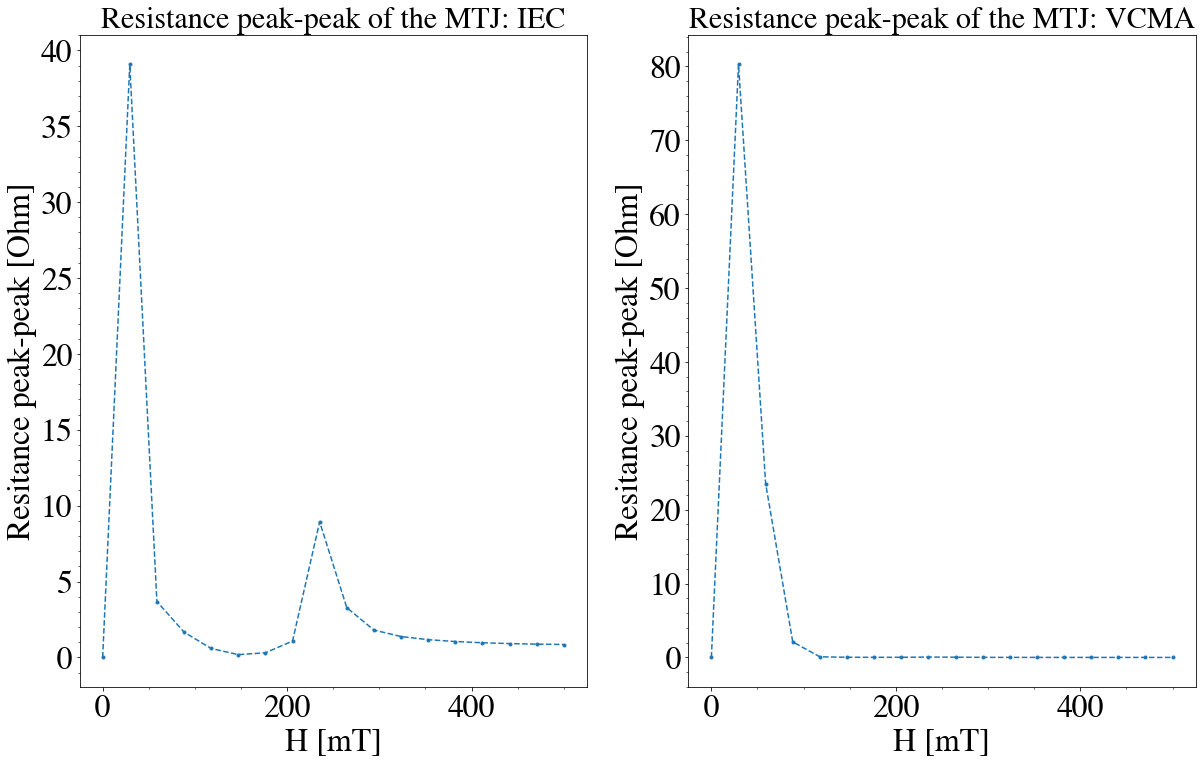

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20,12))

for i, pck in enumerate(zip([coupling_result, anis_result], ['IEC', 'VCMA'])):
    dt, e_type = pck
    ax[i].plot(dt['H'], dt['Rpp'], '.--', label=f'Resistance peak-peak-{e_type}')
    ax[i].set_xlabel("H [mT]")
    ax[i].set_ylabel("Resitance peak-peak [Ohm]")
    ax[i].minorticks_on()
    ax[i].set_title(f"Resistance peak-peak of the MTJ: {e_type}", fontsize=30)

H0:244.27975184538974, dH:0.3910812858784931, Vs:0.27632279288978334, Va:0.043304930526833325, Vback:-4.5575874634487926e-05
H0:246.8427308626604, dH:0.4563551852249441, Vs:-5.048942518209993e-07, Va:0.00033608698613528983, Vback:2.8963041067157535e-07


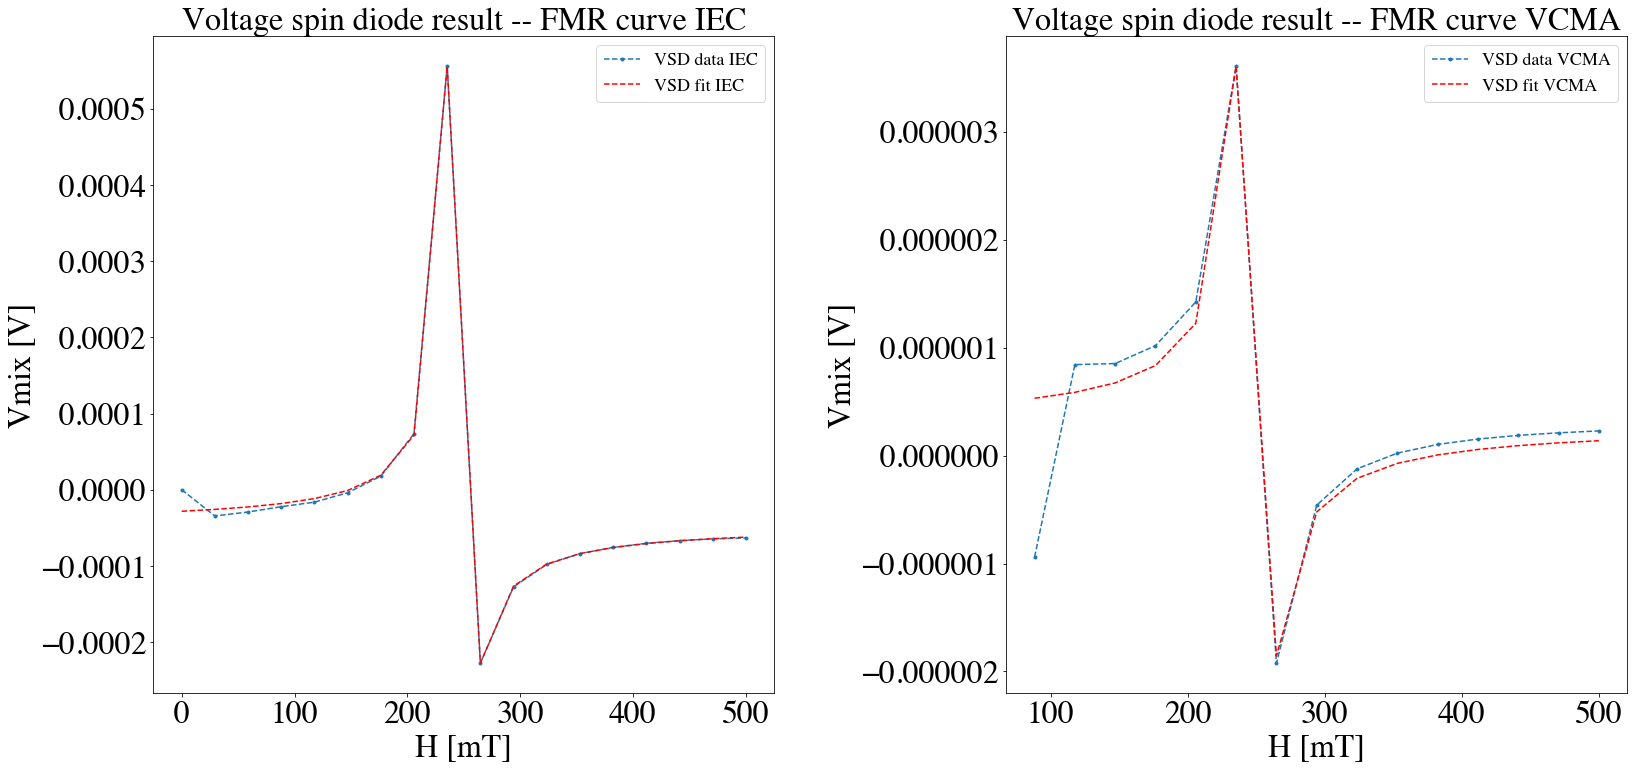

In [9]:
from pymtj.examples.curve_fit import fit_lotentz, lorentz_function

fig, ax = plt.subplots(1, 2, figsize=(24,12))
thresholds = [0, 70]
for i, pck in enumerate(zip([coupling_result, anis_result], ['IEC', 'VCMA'], thresholds)):
    dt, e_type, thres = pck
    tdf = dt.loc[dt['H'] >= thres]
    ax[i].plot(tdf['H'], tdf['Vmix'], '.--', label=f'VSD data {e_type}')
    try:
        H0, dH, Vs, Va, Vback = fit_lotentz(tdf, plot_fit=False)
        y_fit = [lorentz_function(h, H0, dH, Vs, Va, Vback) for h in tdf['H']]
        ax[i].plot(tdf['H'], y_fit, 'r--', label=f'VSD fit {e_type}')
    except:
        pass

    ax[i].set_title(f"Voltage spin diode result -- FMR curve {e_type}", fontsize=32)
    ax[i].set_xlabel("H [mT]")
    ax[i].set_ylabel("Vmix [V]")
    ax[i].legend()
fig.tight_layout(pad=3.0)